<a href="https://colab.research.google.com/github/carmencheong/Email-spam-detection/blob/master/COS30015_ITSecurity_Practical_SpamEmailDetectionEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import pandas as pd

!pip install tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report

from matplotlib import pyplot as plt
import seaborn as sn
import csv
from wordcloud import WordCloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 26.0 MB/s eta 0:00:00


# Data Preparation

## Reading the dataset
### Author: CJM

In [3]:
df=pd.read_csv('/content/subset_emails.csv', encoding = "ISO-8859-1")
df.head(5)

,text,spam
0,Subject: grab this quick triple at its low ho...,1
1,"Subject: yyyy , do you know the hgh difference...",1
2,Subject: make big money with foreclosed real e...,1
3,Subject: are you ready to get it ? hello ! v...,1
4,Subject: letter from : daniel kabila letter f...,1


## Process Data
### Author: CJM

In [4]:
df.columns

Index(['text', 'spam'], dtype='object')

In [5]:
df = df.iloc[:, :2]
df.rename(columns = {'text':'Content', 'spam':'Category'}, inplace = True)
df['Category'] = df['Category'].replace([1], 'spam')
df['Category'] = df['Category'].replace([0], 'ham')
df.tail(5)

,Content,Category
5670,Subject: re : research and development charges...,ham
5671,"Subject: re : receipts from visit jim , than...",ham
5672,Subject: re : enron case study update wow ! a...,ham
5673,"Subject: re : interest david , please , call...",ham
5674,Subject: news : aurora 5 . 2 update aurora ve...,ham


## Understand Data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5675 entries, 0 to 5674
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Content   5675 non-null   object
 1   Category  5675 non-null   object
dtypes: object(2)
memory usage: 88.8+ KB


In [7]:
df.shape

(5675, 2)

In [8]:
df.groupby('Category').describe()

Content                                                            \
           count unique                                                top   
Category                                                                     
ham         4358   4325  Subject: re : eprm 2001 houston  layla ,  my a...   
spam        1317   1317  Subject: grab this quick triple at its low  ho...   

               
         freq  
Category       
ham         2  
spam        1

In [9]:
print('% Imbalanced Data:',1317/4358) # spam count/ham count

% Imbalanced Data: 0.30220284534189995


## Handle Class Imbalance

In [10]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(1317, 2)

In [11]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4358, 2)

In [12]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(1317, 2)

In [13]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(2634, 2)

In [14]:
df_balanced['Category'].value_counts()

ham     1317
spam    1317
Name: Category, dtype: int64

In [15]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Content,Category,spam
1329,Subject: tuesday morning meeting first thing ?...,ham,0
1857,Subject: re : weekly international econ review...,ham,0
2874,"Subject: parameter estimation vince , i have...",ham,0
73,Subject: enhance your anatomy the longz syste...,spam,1
4591,"Subject: re : lsu seminar visit dear vince , ...",ham,0


#### Now the dataset is balanced.

## Encode labels
Making a new 'spam' column
```
if Category is ham
  spam=0
else
  spam=1
```



In [16]:
df['spam']=df['Category'].apply(lambda x: 1 if x=='spam' else 0)
df.head()

,Content,Category,spam
0,Subject: grab this quick triple at its low ho...,spam,1
1,"Subject: yyyy , do you know the hgh difference...",spam,1
2,Subject: make big money with foreclosed real e...,spam,1
3,Subject: are you ready to get it ? hello ! v...,spam,1
4,Subject: letter from : daniel kabila letter f...,spam,1


## Split Data into Training and Testing
Use stratify so that in train and test data distribution of category is equal

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Content'],df_balanced['spam'], stratify=df_balanced['spam'])

In [18]:
X_train.head()

4529    Subject: new resume  dear vince ,  i am so gra...
743     Subject: http : / / www . jumpsociety . com  h...
2500    Subject: your confirmation is needed  please r...
4503    Subject: re : ( no subject )  thanks vince .  ...
3950    Subject: re : b 2 b at enron  tom ,  greg ' s ...
Name: Content, dtype: object

# Model Building

## Download BERT pretrained model

In [19]:
# converts raw text to the numeric input tensors expected by the encoder.
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

# uses the encoder stack of the transformer model to output the representation of each token in the given input.
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [20]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

## Compute cosine similarities between sentence embeddings

In [21]:
c=get_sentence_embeding(['mango','banana','Narendra modi','data analytics','natural language processing'])

### Value near to 1 depict they are similar and 0 depict they are different

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([c[0]],[c[1]])

array([[0.99540985]], dtype=float32)

In [23]:
cosine_similarity([c[3]],[c[4]])

array([[0.96571267]], dtype=float32)

In [24]:
cosine_similarity([c[1]],[c[2]])

array([[0.9482186]], dtype=float32)

## Define a Keras model for classification

In [25]:
#Functional Model

# Bert layers
#Text input passed to bert_preprocess
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
#Processed text passed to bert_encoder
outputs = bert_encoder(preprocessed_text)

# Neural network layers

#Dropout
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [27]:
len(X_train)

1975

In [28]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')]

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

# Model Training and Testing

## Training model

In [29]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
62/62 [==============================] - 34s 343ms/step - loss: 0.6660 - accuracy: 0.6051 - precision: 0.6075 - recall: 0.5927
Epoch 2/10
62/62 [==============================] - 21s 338ms/step - loss: 0.6021 - accuracy: 0.6876 - precision: 0.6947 - recall: 0.6687
Epoch 3/10
62/62 [==============================] - 22s 353ms/step - loss: 0.5539 - accuracy: 0.7418 - precision: 0.7421 - recall: 0.7406
Epoch 4/10
62/62 [==============================] - 22s 353ms/step - loss: 0.5236 - accuracy: 0.7570 - precision: 0.7574 - recall: 0.7558
Epoch 5/10
62/62 [==============================] - 22s 351ms/step - loss: 0.4950 - accuracy: 0.7772 - precision: 0.7888 - recall: 0.7568
Epoch 6/10
62/62 [==============================] - 22s 355ms/step - loss: 0.4693 - accuracy: 0.8005 - precision: 0.8035 - recall: 0.7953
Epoch 7/10
62/62 [==============================] - 21s 346ms/step - loss: 0.4549 - accuracy: 0.8081 - precision: 0.8134 - recall: 0.7994
Epoch 8/10
62/62 [================

In [30]:
model.evaluate(X_test, y_test)

21/21 [==============================] - 9s 368ms/step - loss: 0.3707 - accuracy: 0.8695 - precision: 0.8885 - recall: 0.8455


[0.3706829249858856,
 0.8694992661476135,
 0.8885350227355957,
 0.8454545736312866]

#### We can believe on accuracy as we have balanced the dataset.

## Testing model

In [31]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

21/21 [==============================] - 7s 332ms/step


In [32]:
#If probablity greater than 0.5 than make it 1 otherwise 0.
#If y_predicted=1:spam
#else:Not spam
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,

In [33]:
cm = confusion_matrix(y_test, y_predicted)
cm

array([[294,  35],
       [ 51, 279]])

### Heatmap

Text(50.722222222222214, 0.5, 'Truth')

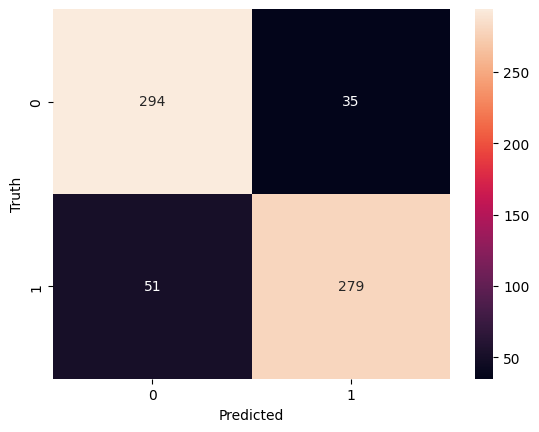

In [34]:
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Classification Report

In [35]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       329
           1       0.89      0.85      0.87       330

    accuracy                           0.87       659
   macro avg       0.87      0.87      0.87       659
weighted avg       0.87      0.87      0.87       659



# Email Prediction

## Load emails

In [42]:
df=pd.read_csv('/content/spams.csv')
df['Category']=df['spam'].apply(lambda x: 'spam' if x==1 else 'ham')
print("Author: CJM")

Author: CJM


## Predict

In [50]:
spams = df['text'].values

# Use your pretrained model to predict spam (1) or not spam (0)
spams_predicted = model.predict(spams)
spams_predicted = spams_predicted.flatten()

# Convert the predictions to binary (0 or 1) based on a threshold (e.g., 0.5 for probability)
threshold = 0.5
binary_predictions = (spams_predicted > threshold).astype(int)

# Assuming all rows in the CSV are labeled as spam (1)
true_labels = np.ones_like(binary_predictions)
spams_predicted

2/2 [==============================] - 0s 373ms/step


array([0.8396563 , 0.7801875 , 0.584159  , 0.41814053, 0.8728878 ,
       0.8760772 , 0.5249259 , 0.8311479 , 0.56251836, 0.86864686,
       0.49953023, 0.8584132 , 0.67516226, 0.55910736, 0.4887584 ,
       0.78190845, 0.85602504, 0.7003051 , 0.65254337, 0.4763185 ,
       0.9182575 , 0.27576986, 0.8574966 , 0.8762888 , 0.8246535 ,
       0.56504726, 0.857152  , 0.79526955, 0.7830738 , 0.85279965,
       0.7920026 , 0.42567262, 0.60427856, 0.765083  , 0.74655575,
       0.37005657, 0.7973959 , 0.9171054 , 0.8586669 , 0.70718384,
       0.70704347, 0.7129852 , 0.70365644, 0.934425  , 0.8899076 ,
       0.55685604, 0.9063729 , 0.4777054 , 0.6134257 , 0.29012784,
       0.29489103], dtype=float32)

## Confusion Matrix

In [45]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, binary_predictions)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 0  0]
 [10 41]]


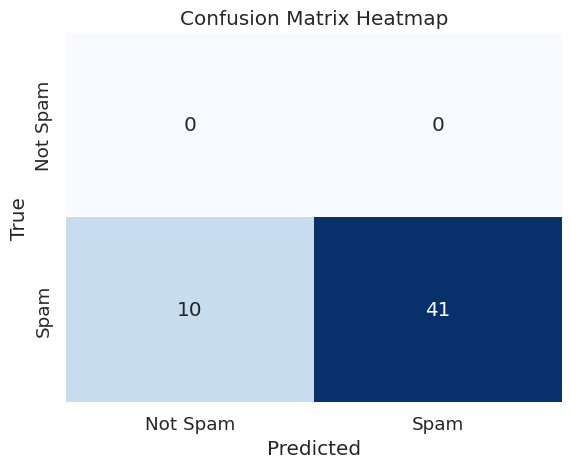

In [46]:
# Create a heatmap
sn.set(font_scale=1.2)
sn.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [47]:
# Generate and print classification report
classification_rep = classification_report(true_labels, binary_predictions)
print("\nClassification Report:")
print(classification_rep)



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.80      0.89        51

    accuracy                           0.80        51
   macro avg       0.50      0.40      0.45        51
weighted avg       1.00      0.80      0.89        51



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Conclude the prediction
### Author: CJM
* Each number in the array represents the model's prediction for a specific input.
* These numbers are often between 0 and 1, where 0 means low confidence and 1 means high confidence.
* Since this is a binary classification problem (i.e., model is predicting one of two classes, such as "positive" or "negative"), the numbers represent the probability that the input belongs to the positive class. In this case:


1.   Values **close to 0** indicate the model believes the input is likely to be in the negative (ham) class.
2.   Values **close to 1** indicate the model believes the input is likely to be in the positive (spam) class.

# Data Visualization and Analysis

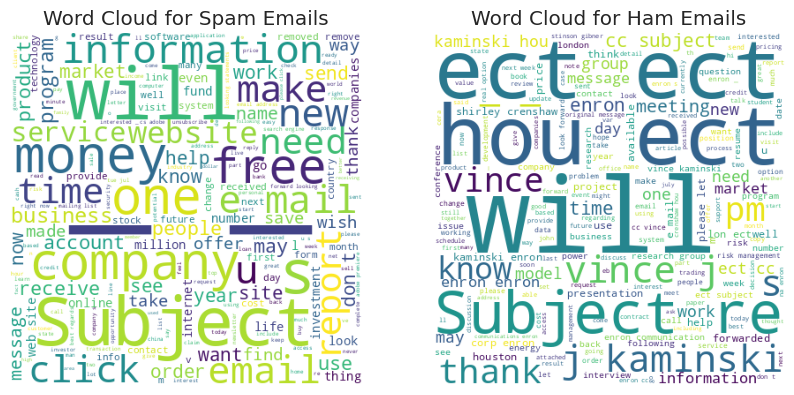

In [48]:
# Create separate dataframes for spam and ham emails
spam_df_balanced = df_balanced[df_balanced['spam'] == 1]
ham_df_balanced = df_balanced[df_balanced['spam'] == 0]

# Function to generate word cloud and return the image
def generate_word_cloud_image(text):
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate(text)
    return wordcloud.to_image()

# Generate word clouds for spam and ham emails
spam_wordcloud_image = generate_word_cloud_image(" ".join(spam_df_balanced['Content']))
ham_wordcloud_image = generate_word_cloud_image(" ".join(ham_df_balanced['Content']))

# Create a figure with subplots for the word clouds
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(spam_wordcloud_image)
axes[0].set_title("Word Cloud for Spam Emails")
axes[0].axis('off')
axes[1].imshow(ham_wordcloud_image)
axes[1].set_title("Word Cloud for Ham Emails")
axes[1].axis('off')

plt.show()

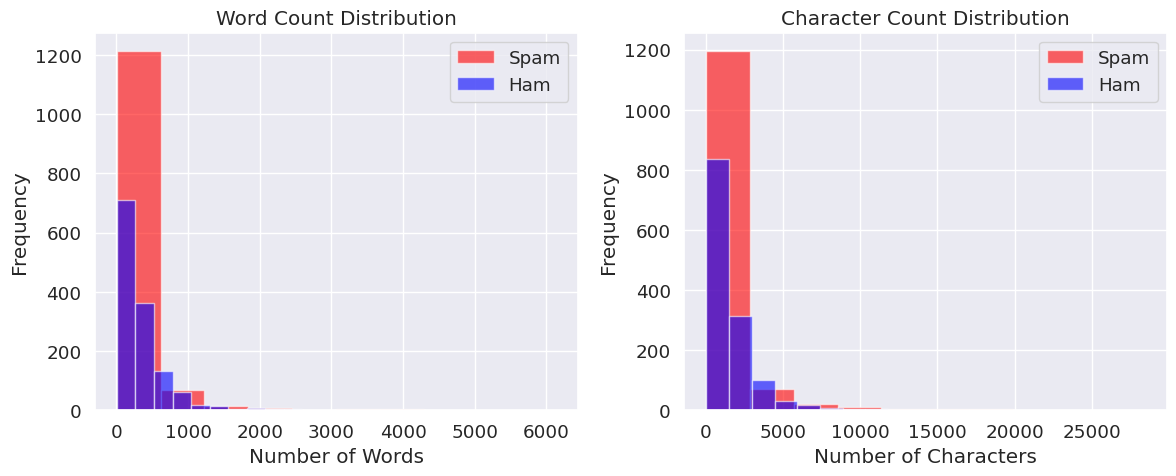

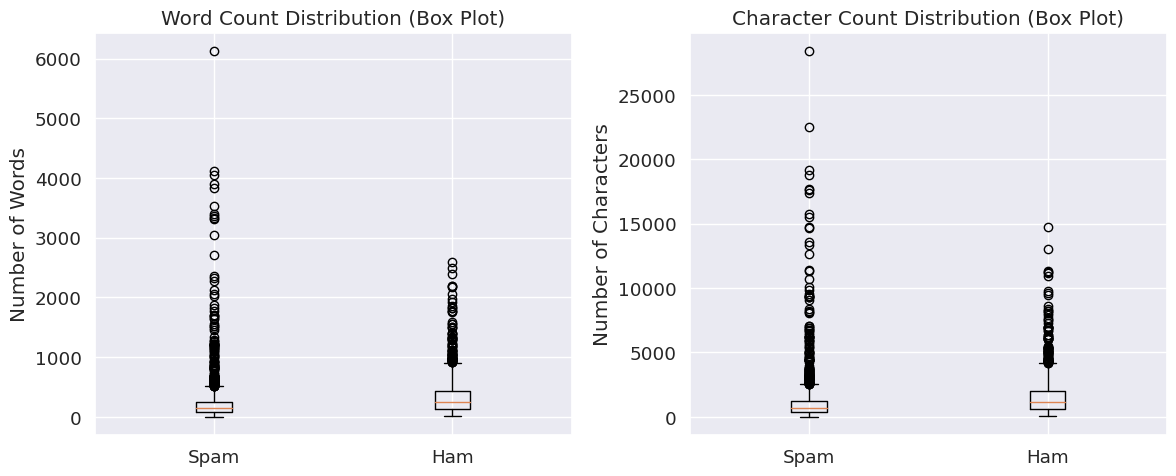

In [49]:
# Calculate text lengths (number of words and characters)
df_balanced['Word_Count'] = df_balanced['Content'].apply(lambda x: len(x.split()))
df_balanced['Char_Count'] = df_balanced['Content'].apply(len)

# Create histograms for word counts
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.hist(df_balanced[df_balanced['spam'] == 1]['Word_Count'], color='red', alpha=0.6, label='Spam')
plt.hist(df_balanced[df_balanced['spam'] == 0]['Word_Count'], color='blue', alpha=0.6, label='Ham')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Word Count Distribution')
plt.legend()

# Create histograms for character counts
plt.subplot(122)
plt.hist(df_balanced[df_balanced['spam'] == 1]['Char_Count'], color='red', alpha=0.6, label='Spam')
plt.hist(df_balanced[df_balanced['spam'] == 0]['Char_Count'], color='blue', alpha=0.6, label='Ham')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.title('Character Count Distribution')
plt.legend()

plt.tight_layout()
plt.show()

# Create box plots for word and character counts
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.boxplot([df_balanced[df_balanced['spam'] == 1]['Word_Count'], df_balanced[df_balanced['spam'] == 0]['Word_Count']], labels=['Spam', 'Ham'])
plt.ylabel('Number of Words')
plt.title('Word Count Distribution (Box Plot)')

plt.subplot(122)
plt.boxplot([df_balanced[df_balanced['spam'] == 1]['Char_Count'], df_balanced[df_balanced['spam'] == 0]['Char_Count']], labels=['Spam', 'Ham'])
plt.ylabel('Number of Characters')
plt.title('Character Count Distribution (Box Plot)')

plt.tight_layout()
plt.show()